# High-Level Setup & Imports

In [1]:
# General Python Packages
import os, time, numbers, math

# Torch Packages
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.optim import lr_scheduler, SGD
from torch.autograd import Variable
from torch import nn
from torch.nn import DataParallel
from torch.nn import Module

# General Analytics Packages
import pandas as pd
import numpy as np

# Visualization / Image Packages
import matplotlib.pyplot as plt
from PIL import Image

# Randomization Functions
from random import random as randuni

In [2]:
# Put MatPlotLib in interactive mode
plt.ion()

# Plot graphics inline in the notebook
%matplotlib inline

# Define Classes and Functions

### Image Data Utility Classes

In [3]:
def is_image_file(fname):
    """Checks if a file is an image.
    Args:
        fname (string): path to a file
    Returns:
        bool: True if the filename ends with a known image extension
    """
    return fname.lower().endswith('.png')

def create_label_maps(details_df):
    """ Take a descriptive dataframe and extract the unique labels and map to index values
    Args:
        details_df: Dataframe with the image details
    Returns:
        label_list: list of unique labels in the dataframe
        label_to_index: map from labels to indices
    """
    """ TODO: Research paper also excludes these labels but need to figure out how to handle
              cases that have these as positive findings (completely exclude?)
    excluded_labels = ['Edema','Hernia','Emphysema','Fibrosis','No Finding'
                      'Pleural_Thickening','Consolidation']
    """
    excluded_labels = ['No Finding']
    
    label_groups = details_df['Finding Labels'].unique()
    unique_labels = set([label for sublist in label_groups.tolist() for label in sublist.split('|')])
    
    # Drop some label that we do not want to include
    unique_labels = [l for l in unique_labels if l not in excluded_labels]

    index_to_label = {idx: val for idx, val in enumerate(unique_labels)}
    label_to_index = {val: idx for idx, val in index_to_label.items()}

    label_list = list(label_to_index.keys())

    return label_list, label_to_index

def create_image_list(dir):
    """ Create a full list of images available 
    Args:
        dir (string): root directory of images with subdirectories underneath
                      that have the .png images within them
    Returns:
        image_list: list of tuples with (image_name, full_image_path)
    """
    image_list = []
    dir = os.path.expanduser(dir)
    for subfolder in sorted(os.listdir(dir)):
        d = os.path.join(dir, subfolder)
        if not os.path.isdir(d):
            continue
        for subfolder_path, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if is_image_file(fname):
                    path = os.path.join(subfolder_path, fname)
                    image_list.append((fname, path))
    return image_list

def pil_loader(path):
    """ Opens path as file with Pillow (https://github.com/python-pillow/Pillow/issues/835)
    Args:
        path (string): File path to the image
    Returns:
        img: Image in RGB format
    """
    f = open(path, 'rb')
    return Image.open(f)
    #with open(path, 'rb') as f:
    #    return Image.open(f)
        #with Image.open(f) as img:
        #    return img.load()
        
def imshow(inp, title=None):
    """ Convert tensor array to an image (only use post-dataset transform) """
    inp = inp[0]
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

### Torch Dataset Definition

In [4]:
class XrayImageSet(Dataset):
    """
    Args:
        image_root (string): root directory of the images in form image/subfolder/*.png
        csv_file (string): path to the CSV data file
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
     Attributes:
        labels (list): list of the possible label names.
        label_to_index (dict): look from label name to a label index
        imgs (list): List of (filename, image path) tuples
    """
    
    def __init__(self, image_root, csv_file, transform=None, target_transform=None, loader = pil_loader):
        """ Create an instance of the Xray Dataset """
        img_details = pd.read_csv(csv_file)
        
        labels, label_to_index = create_label_maps(img_details)
        imgs = create_image_list(image_root)

        self.imgs = imgs
        self.image_details = img_details
        self.image_root = image_root
        self.labels = labels
        self.label_to_index = label_to_index
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.max_label_index = max(label_to_index.values())

    def __getitem__(self, index):
        """ Get image,labels pair by index
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """
        fname, path = self.imgs[index]
        target = self.get_one_hot_labels(fname)
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        """ Calculate length of the dataset (number of images) """
        return len(self.imgs)
    
    def get_labels(self, fname):
        """ Return the label string for the file """
        return self.image_details[self.image_details['Image Index'] == fname]['Finding Labels'].values[0]
    
    def one_hot_labels(self, labels):
        """ Convert the labels string (with each label separated by |) into 1-hot encoding """
        if labels == None:
            return None
        
        split_label_indices = [self.label_to_index.get(label)
                               for label in labels.split('|')
                               if label != 'No Finding']
        
        out = [1 if idx in split_label_indices else 0 for idx in range(self.max_label_index+1)]
        # This code UNHOTs the labels:
        # out = '|'.join([index_to_label.get(idx) for idx, val in enumerate(one_hot_tuple) if val == 1])
        return out

    def get_one_hot_labels(self, fname):
        """ Get the 1-hot encoded label array for the provided file """
        labels = self.get_labels(fname)
        one_hot_labels = self.one_hot_labels(labels)
        return torch.FloatTensor(one_hot_labels)

### Model Training Output Writer

In [5]:
class printer_writer:
    def __init__(self, output_folder_path):
        self.start_time = time.strftime('%Y%m%d-%Hh%Mm%Ss')
        
        self.outprefix = output_folder_path + '/' + self.start_time
        
        # Print Output File
        self.print_out_path = self.outprefix + '_print.txt'
        self.print_out_file = open(self.print_out_path, 'w', 1)
        
    def printw(self, string):
        print(string)
        try:
            self.print_out_file.write(string + "\n")
        except: # Ignore errors
            pass
        
    def save_checkpoint(self, epoch, model, optimizer, scheduler, val_error):
        model_out_path = self.outprefix + '_model_' + str(epoch+1) + '.tar'
        
        torch.save({
            'epoch': epoch+1,
            'state': model.state_dict(),
            'optimizer': optimizer,
            'scheduler': scheduler,
            'val_error': val_error
        }, model_out_path)
        
    def close(self):
        self.print_out_file.close()

### Model Training Procedure

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, outfolder = '/user/xrayproj/output/'):
    since = time.time()
    scribe = printer_writer(outfolder)

    for epoch in range(num_epochs):
        scribe.printw('Epoch {}/{}'.format(epoch, num_epochs - 1))
        scribe.printw('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0
            obs_counter = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Store statistics (convert from autograd.Variable to float/int)
                loss_val = loss.data[0]
                correct_val = torch.sum( ((outputs.sigmoid()>0.5) == (labels>0.5)).long() ).data[0]
                
                running_loss += loss_val
                running_corrects += correct_val
                
                obs_counter += len(inputs)
                
                batch_loss = 1.0 * loss_val / len(inputs)
                batch_acc = 1.0 * correct_val / len(inputs)
                status = ' |~~ {}@{}  Loss: {:.6f} Acc: {:.4f}'.format(
                    phase, obs_counter, batch_loss, batch_acc)
                scribe.printw(status)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            scribe.printw('{}  Loss: {:.6f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Store the model on disk
            if phase == 'val':
                scheduler.step(epoch_loss)
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scribe.save_checkpoint(epoch, model, optimizer, None, epoch_loss)
                else:
                    scribe.save_checkpoint(epoch, model, optimizer, scheduler, epoch_loss)

    time_elapsed = time.time() - since
    scribe.printw('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    scribe.close()

    return model

### Customized Binary Cross Entropy Loss Function

In [7]:
class BCEWithLogitsImbalanceWeightedLoss(Module):
    def __init__(self, class_weight=None, size_average=True):
        super(BCEWithLogitsImbalanceWeightedLoss, self).__init__()
        self.size_average = size_average

    def forward(self, input, target):
        return self.imbalance_weighted_bce_with_logit(input, target, size_average=self.size_average)
    
    def imbalance_weighted_bce_with_logit(self, input, target, size_average=True):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()

        # Determine |P| and |N|
        positive_labels = target.sum()
        negative_labels = (1-target).sum()

        # Upweight the less common class (very often the 1s)
        beta_p = (positive_labels + negative_labels) / positive_labels
        beta_n = (positive_labels + negative_labels) / negative_labels

        # Adjust the losses accordingly
        loss_weight = target * beta_p + (1-target) * beta_n

        loss = loss * loss_weight

        if size_average:
            return loss.mean()
        else:
            return loss.sum()

### Define model types

In [8]:
def ResNetBase(base_size = 18, only_update_fc = True, pretrain = True):
    """ ResNet 18 with only final FC layer updatable """
    m = None
    if base_size == 18:
        m = models.resnet18(pretrained=pretrain)
    elif base_size == 34:
        m = models.resnet34(pretrained=pretrain)
    elif base_size == 50:
        m = models.resnet50(pretrained=pretrain)
    elif base_size == 101:
        m = models.resnet101(pretrained=pretrain)
    elif base_size == 152:
        m = models.resnet152(pretrained=pretrain)
    
    if only_update_fc:
        for param in m.parameters():
            param.requires_grad = False

    m.fc = nn.Linear(m.fc.in_features, len(img_data_train.labels))
    
    return m

#### mean ± std. dev. of 7 runs, 10000000 loops each

#### Time for __get_item__
```
%timeit img_data_train[3] # 30.8 ms ± 544 µs per loop
```

#### Breakdown for __get_item__
```
%timeit img_data_train.imgs[8] # 63 ns ± 0.0057 ns per loop
%timeit img_data_train.get_one_hot_labels('00011558_012.png') # 8.72 ms ± 9.44 µs per loop
%timeit img_data_train.loader('/user/images/images_006/00011558_012.png') # 14.1 ms ± 3.41 µs per loop
%timeit img_data_train.transform(img) # 3.17 ms ± 1.32 µs per loop
```

#### Breakdown for loader() from __get_item__
```
%timeit open('/user/images/images_006/00011558_012.png', 'rb') # 7.72 µs ± 13.4 ns per loop
%timeit Image.open(f) # 37.5 µs ± 2.25 µs per loop
%timeit img.convert('RGB') # 498 µs ± 149 ns per loop
```

# Setup and Begin Training Model

### Data Setup

In [9]:
nn_input_size = 224 #1024
batch_size = 64
pin_mem_setting = True
num_gpus = torch.cuda.device_count()
num_workers = 10

print("Number of GPU: {}".format(num_gpus))

Number of GPU: 1


In [10]:
img_transforms_train = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [11]:
img_transforms_nontrain = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [12]:
img_data_train = XrayImageSet(image_root = '/user/images_processed/',
                              csv_file = '/user/img_details.csv',
                              transform = img_transforms_train,
                              target_transform = None)

img_data_train.imgs = [img for i, img in enumerate(img_data_train.imgs) if i % 10 >= 3]

In [13]:
img_data_val   = XrayImageSet(image_root = '/user/images_processed/',
                              csv_file = '/user/img_details.csv',
                              transform = img_transforms_nontrain,
                              target_transform = None)

img_data_val.imgs = [img for i, img in enumerate(img_data_val.imgs) if i % 10 in (1,2)]

In [14]:
img_data_test  = XrayImageSet(image_root = '/user/images_processed/',
                              csv_file = '/user/img_details.csv',
                              transform = img_transforms_nontrain,
                              target_transform = None)

img_data_test.imgs = [img for i, img in enumerate(img_data_test.imgs) if i % 10 == 0]

In [15]:
train_set = set(img_data_train.imgs)
val_set = set(img_data_val.imgs)
test_set = set(img_data_test.imgs)
assert len(train_set.intersection(val_set)) == 0
assert len(train_set.intersection(test_set)) == 0
assert len(val_set.intersection(test_set)) == 0

In [16]:
print("Training Set Size: {}".format(len(img_data_train)))
print("Validation Set Size: {}".format(len(img_data_val)))
print("Test Set Size: {}".format(len(img_data_test)))

Training Set Size: 78484
Validation Set Size: 22424
Test Set Size: 11212


In [17]:
img_loader_train = DataLoader(img_data_train,
                              batch_size = batch_size * num_gpus,
                              shuffle = True,
                              num_workers = num_workers,
                              pin_memory = pin_mem_setting)

img_loader_val   = DataLoader(img_data_val,
                              batch_size = batch_size * num_gpus,
                              shuffle = True,
                              num_workers = num_workers,
                              pin_memory = pin_mem_setting)

In [18]:
dataloaders = {
    'train': img_loader_train,
    'val': img_loader_val
}

In [42]:
model_base = ResNetBase(base_size = 18, only_update_fc = False, pretrain = True)

In [43]:
model_ft = DataParallel(model_base).cuda()

### Setup learning rates and procedures

In [21]:
#criterion = BCEWithLogitsImbalanceWeightedLoss()
criterion_base = nn.BCEWithLogitsLoss()

#optimizer_ft = SGD(model_ft.module.fc.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
#lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
learning_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, patience=0)

In [22]:
criterion = criterion_base.cuda()

### Future code for allowing optimization of the base layer with a lower learning rate

```
ignored_params = list(map(id, model.fc.parameters()))
base_params = filter(lambda p: id(p) not in ignored_params,
                     model.parameters())

optimizer = torch.optim.SGD([
            {'params': base_params},
            {'params': model.fc.parameters(), 'lr': opt.lr}
        ], lr=opt.lr*0.1, momentum=0.9)
```

# Begin Training Network

In [23]:
train_model(model_ft,
            criterion,
            optimizer_ft,
            learning_scheduler,
            num_epochs=2)

Epoch 0/1
----------
 |~~ train@64  Loss: 0.012953 Acc: 5.2969
 |~~ train@128  Loss: 0.011693 Acc: 6.2031
 |~~ train@192  Loss: 0.009778 Acc: 8.7188
 |~~ train@256  Loss: 0.007692 Acc: 12.0625
 |~~ train@320  Loss: 0.005637 Acc: 13.3750
 |~~ train@384  Loss: 0.004490 Acc: 13.2656
 |~~ train@448  Loss: 0.003774 Acc: 13.2188
 |~~ train@512  Loss: 0.003053 Acc: 13.3750
 |~~ train@576  Loss: 0.003211 Acc: 13.2344
 |~~ train@640  Loss: 0.002711 Acc: 13.3594
 |~~ train@704  Loss: 0.002852 Acc: 13.3125
 |~~ train@768  Loss: 0.002497 Acc: 13.4375
 |~~ train@832  Loss: 0.003038 Acc: 13.3125
 |~~ train@896  Loss: 0.003136 Acc: 13.3125
 |~~ train@960  Loss: 0.003075 Acc: 13.2969
 |~~ train@1024  Loss: 0.003488 Acc: 13.2344
 |~~ train@1088  Loss: 0.004277 Acc: 13.1094
 |~~ train@1152  Loss: 0.002768 Acc: 13.4219
 |~~ train@1216  Loss: 0.003468 Acc: 13.2812
 |~~ train@1280  Loss: 0.003182 Acc: 13.2969
 |~~ train@1344  Loss: 0.003865 Acc: 13.2500
 |~~ train@1408  Loss: 0.003369 Acc: 13.2969
 |~~ tra

 |~~ train@11776  Loss: 0.003463 Acc: 13.0469
 |~~ train@11840  Loss: 0.002685 Acc: 13.2344
 |~~ train@11904  Loss: 0.003034 Acc: 13.1406
 |~~ train@11968  Loss: 0.002505 Acc: 13.2656
 |~~ train@12032  Loss: 0.003113 Acc: 13.2344
 |~~ train@12096  Loss: 0.002340 Acc: 13.3906
 |~~ train@12160  Loss: 0.002766 Acc: 13.2031
 |~~ train@12224  Loss: 0.002423 Acc: 13.3438
 |~~ train@12288  Loss: 0.001877 Acc: 13.5156
 |~~ train@12352  Loss: 0.002992 Acc: 13.2031
 |~~ train@12416  Loss: 0.002778 Acc: 13.2344
 |~~ train@12480  Loss: 0.002109 Acc: 13.4844
 |~~ train@12544  Loss: 0.002920 Acc: 13.2812
 |~~ train@12608  Loss: 0.003268 Acc: 12.9688
 |~~ train@12672  Loss: 0.002772 Acc: 13.2344
 |~~ train@12736  Loss: 0.003035 Acc: 13.1875
 |~~ train@12800  Loss: 0.002487 Acc: 13.3281
 |~~ train@12864  Loss: 0.002678 Acc: 13.2969
 |~~ train@12928  Loss: 0.002996 Acc: 13.1719
 |~~ train@12992  Loss: 0.002467 Acc: 13.3281
 |~~ train@13056  Loss: 0.002708 Acc: 13.2500
 |~~ train@13120  Loss: 0.002599 A

 |~~ train@23296  Loss: 0.002614 Acc: 13.3281
 |~~ train@23360  Loss: 0.002965 Acc: 13.1562
 |~~ train@23424  Loss: 0.002436 Acc: 13.3125
 |~~ train@23488  Loss: 0.002613 Acc: 13.2344
 |~~ train@23552  Loss: 0.002830 Acc: 13.2344
 |~~ train@23616  Loss: 0.002325 Acc: 13.3906
 |~~ train@23680  Loss: 0.002658 Acc: 13.3281
 |~~ train@23744  Loss: 0.003229 Acc: 13.1875
 |~~ train@23808  Loss: 0.003518 Acc: 13.0000
 |~~ train@23872  Loss: 0.002014 Acc: 13.4844
 |~~ train@23936  Loss: 0.002407 Acc: 13.3438
 |~~ train@24000  Loss: 0.002602 Acc: 13.2812
 |~~ train@24064  Loss: 0.002664 Acc: 13.3125
 |~~ train@24128  Loss: 0.002707 Acc: 13.2344
 |~~ train@24192  Loss: 0.002253 Acc: 13.3750
 |~~ train@24256  Loss: 0.002550 Acc: 13.3125
 |~~ train@24320  Loss: 0.002268 Acc: 13.3906
 |~~ train@24384  Loss: 0.002484 Acc: 13.3281
 |~~ train@24448  Loss: 0.003155 Acc: 13.1719
 |~~ train@24512  Loss: 0.002281 Acc: 13.4375
 |~~ train@24576  Loss: 0.002605 Acc: 13.3594
 |~~ train@24640  Loss: 0.002576 A

 |~~ train@34752  Loss: 0.002525 Acc: 13.2656
 |~~ train@34816  Loss: 0.002508 Acc: 13.2656
 |~~ train@34880  Loss: 0.002684 Acc: 13.3281
 |~~ train@34944  Loss: 0.002366 Acc: 13.3438
 |~~ train@35008  Loss: 0.002431 Acc: 13.4062
 |~~ train@35072  Loss: 0.002173 Acc: 13.4531
 |~~ train@35136  Loss: 0.002669 Acc: 13.2188
 |~~ train@35200  Loss: 0.002238 Acc: 13.3594
 |~~ train@35264  Loss: 0.002315 Acc: 13.3438
 |~~ train@35328  Loss: 0.002754 Acc: 13.2188
 |~~ train@35392  Loss: 0.002480 Acc: 13.3438
 |~~ train@35456  Loss: 0.002920 Acc: 13.2188
 |~~ train@35520  Loss: 0.002719 Acc: 13.1719
 |~~ train@35584  Loss: 0.002833 Acc: 13.1719
 |~~ train@35648  Loss: 0.002203 Acc: 13.3438
 |~~ train@35712  Loss: 0.002243 Acc: 13.4531
 |~~ train@35776  Loss: 0.002324 Acc: 13.3594
 |~~ train@35840  Loss: 0.002740 Acc: 13.2812
 |~~ train@35904  Loss: 0.003008 Acc: 13.1094
 |~~ train@35968  Loss: 0.003056 Acc: 13.0781
 |~~ train@36032  Loss: 0.002435 Acc: 13.3906
 |~~ train@36096  Loss: 0.002917 A

 |~~ train@46272  Loss: 0.002639 Acc: 13.2500
 |~~ train@46336  Loss: 0.003027 Acc: 13.2500
 |~~ train@46400  Loss: 0.002761 Acc: 13.2344
 |~~ train@46464  Loss: 0.002464 Acc: 13.3594
 |~~ train@46528  Loss: 0.003020 Acc: 13.0625
 |~~ train@46592  Loss: 0.002693 Acc: 13.2500
 |~~ train@46656  Loss: 0.002213 Acc: 13.3906
 |~~ train@46720  Loss: 0.002313 Acc: 13.3594
 |~~ train@46784  Loss: 0.002474 Acc: 13.3125
 |~~ train@46848  Loss: 0.002611 Acc: 13.2188
 |~~ train@46912  Loss: 0.001967 Acc: 13.4531
 |~~ train@46976  Loss: 0.002841 Acc: 13.2188
 |~~ train@47040  Loss: 0.002211 Acc: 13.3906
 |~~ train@47104  Loss: 0.002543 Acc: 13.2656
 |~~ train@47168  Loss: 0.002208 Acc: 13.3594
 |~~ train@47232  Loss: 0.002349 Acc: 13.4375
 |~~ train@47296  Loss: 0.002860 Acc: 13.2188
 |~~ train@47360  Loss: 0.002032 Acc: 13.4531
 |~~ train@47424  Loss: 0.002885 Acc: 13.1250
 |~~ train@47488  Loss: 0.001910 Acc: 13.5156
 |~~ train@47552  Loss: 0.002668 Acc: 13.2656
 |~~ train@47616  Loss: 0.003138 A

 |~~ train@57792  Loss: 0.002579 Acc: 13.2812
 |~~ train@57856  Loss: 0.002500 Acc: 13.2656
 |~~ train@57920  Loss: 0.001969 Acc: 13.4531
 |~~ train@57984  Loss: 0.002565 Acc: 13.3281
 |~~ train@58048  Loss: 0.002201 Acc: 13.3750
 |~~ train@58112  Loss: 0.002310 Acc: 13.3125
 |~~ train@58176  Loss: 0.002335 Acc: 13.3906
 |~~ train@58240  Loss: 0.002100 Acc: 13.4062
 |~~ train@58304  Loss: 0.002502 Acc: 13.3750
 |~~ train@58368  Loss: 0.002510 Acc: 13.2344
 |~~ train@58432  Loss: 0.002123 Acc: 13.4375
 |~~ train@58496  Loss: 0.002592 Acc: 13.2812
 |~~ train@58560  Loss: 0.002658 Acc: 13.2188
 |~~ train@58624  Loss: 0.002445 Acc: 13.2812
 |~~ train@58688  Loss: 0.003142 Acc: 13.0938
 |~~ train@58752  Loss: 0.002143 Acc: 13.4062
 |~~ train@58816  Loss: 0.002370 Acc: 13.3438
 |~~ train@58880  Loss: 0.001906 Acc: 13.4844
 |~~ train@58944  Loss: 0.002482 Acc: 13.2656
 |~~ train@59008  Loss: 0.002855 Acc: 13.2500
 |~~ train@59072  Loss: 0.003206 Acc: 13.1719
 |~~ train@59136  Loss: 0.002208 A

 |~~ train@69312  Loss: 0.002960 Acc: 13.0938
 |~~ train@69376  Loss: 0.002596 Acc: 13.3438
 |~~ train@69440  Loss: 0.002158 Acc: 13.3594
 |~~ train@69504  Loss: 0.002448 Acc: 13.2969
 |~~ train@69568  Loss: 0.001773 Acc: 13.5000
 |~~ train@69632  Loss: 0.002576 Acc: 13.1875
 |~~ train@69696  Loss: 0.002704 Acc: 13.1406
 |~~ train@69760  Loss: 0.002843 Acc: 13.0625
 |~~ train@69824  Loss: 0.002505 Acc: 13.3125
 |~~ train@69888  Loss: 0.002469 Acc: 13.2500
 |~~ train@69952  Loss: 0.002122 Acc: 13.4844
 |~~ train@70016  Loss: 0.002593 Acc: 13.2344
 |~~ train@70080  Loss: 0.002574 Acc: 13.2969
 |~~ train@70144  Loss: 0.002496 Acc: 13.2656
 |~~ train@70208  Loss: 0.002691 Acc: 13.2969
 |~~ train@70272  Loss: 0.002505 Acc: 13.2969
 |~~ train@70336  Loss: 0.002628 Acc: 13.2656
 |~~ train@70400  Loss: 0.002162 Acc: 13.3281
 |~~ train@70464  Loss: 0.002415 Acc: 13.2656
 |~~ train@70528  Loss: 0.002055 Acc: 13.4375
 |~~ train@70592  Loss: 0.002669 Acc: 13.2344
 |~~ train@70656  Loss: 0.001762 A

 |~~ val@2432  Loss: 0.002644 Acc: 13.1406
 |~~ val@2496  Loss: 0.002576 Acc: 13.2188
 |~~ val@2560  Loss: 0.003060 Acc: 13.1562
 |~~ val@2624  Loss: 0.002876 Acc: 13.1406
 |~~ val@2688  Loss: 0.002031 Acc: 13.4219
 |~~ val@2752  Loss: 0.003272 Acc: 13.0312
 |~~ val@2816  Loss: 0.002553 Acc: 13.2969
 |~~ val@2880  Loss: 0.002356 Acc: 13.2656
 |~~ val@2944  Loss: 0.002647 Acc: 13.2031
 |~~ val@3008  Loss: 0.003035 Acc: 13.0938
 |~~ val@3072  Loss: 0.001907 Acc: 13.4062
 |~~ val@3136  Loss: 0.002776 Acc: 13.2188
 |~~ val@3200  Loss: 0.002946 Acc: 13.1562
 |~~ val@3264  Loss: 0.002748 Acc: 13.2188
 |~~ val@3328  Loss: 0.002846 Acc: 13.0781
 |~~ val@3392  Loss: 0.003006 Acc: 13.1094
 |~~ val@3456  Loss: 0.001865 Acc: 13.5312
 |~~ val@3520  Loss: 0.003143 Acc: 13.0156
 |~~ val@3584  Loss: 0.002660 Acc: 13.3281
 |~~ val@3648  Loss: 0.002298 Acc: 13.3438
 |~~ val@3712  Loss: 0.002514 Acc: 13.3281
 |~~ val@3776  Loss: 0.002433 Acc: 13.2812
 |~~ val@3840  Loss: 0.002463 Acc: 13.3281
 |~~ val@39

 |~~ val@14656  Loss: 0.002409 Acc: 13.3281
 |~~ val@14720  Loss: 0.001977 Acc: 13.4688
 |~~ val@14784  Loss: 0.002590 Acc: 13.3281
 |~~ val@14848  Loss: 0.002353 Acc: 13.3750
 |~~ val@14912  Loss: 0.002384 Acc: 13.3750
 |~~ val@14976  Loss: 0.002645 Acc: 13.2188
 |~~ val@15040  Loss: 0.002265 Acc: 13.3750
 |~~ val@15104  Loss: 0.002666 Acc: 13.1875
 |~~ val@15168  Loss: 0.002950 Acc: 13.2656
 |~~ val@15232  Loss: 0.002507 Acc: 13.2344
 |~~ val@15296  Loss: 0.002565 Acc: 13.2188
 |~~ val@15360  Loss: 0.002328 Acc: 13.2656
 |~~ val@15424  Loss: 0.002331 Acc: 13.2656
 |~~ val@15488  Loss: 0.002355 Acc: 13.3438
 |~~ val@15552  Loss: 0.002550 Acc: 13.2812
 |~~ val@15616  Loss: 0.002267 Acc: 13.4062
 |~~ val@15680  Loss: 0.001937 Acc: 13.4531
 |~~ val@15744  Loss: 0.002840 Acc: 13.2812
 |~~ val@15808  Loss: 0.002114 Acc: 13.3438
 |~~ val@15872  Loss: 0.002069 Acc: 13.3750
 |~~ val@15936  Loss: 0.002568 Acc: 13.2969
 |~~ val@16000  Loss: 0.003347 Acc: 13.0156
 |~~ val@16064  Loss: 0.002880 A

 |~~ train@3968  Loss: 0.002080 Acc: 13.3438
 |~~ train@4032  Loss: 0.002286 Acc: 13.2500
 |~~ train@4096  Loss: 0.002750 Acc: 13.2344
 |~~ train@4160  Loss: 0.002031 Acc: 13.4375
 |~~ train@4224  Loss: 0.002445 Acc: 13.2344
 |~~ train@4288  Loss: 0.002410 Acc: 13.2188
 |~~ train@4352  Loss: 0.002562 Acc: 13.1719
 |~~ train@4416  Loss: 0.002057 Acc: 13.3438
 |~~ train@4480  Loss: 0.002717 Acc: 13.1875
 |~~ train@4544  Loss: 0.002279 Acc: 13.4062
 |~~ train@4608  Loss: 0.002057 Acc: 13.4375
 |~~ train@4672  Loss: 0.002419 Acc: 13.2969
 |~~ train@4736  Loss: 0.002028 Acc: 13.3750
 |~~ train@4800  Loss: 0.002480 Acc: 13.2500
 |~~ train@4864  Loss: 0.002464 Acc: 13.2031
 |~~ train@4928  Loss: 0.002601 Acc: 13.3125
 |~~ train@4992  Loss: 0.002685 Acc: 13.2812
 |~~ train@5056  Loss: 0.002210 Acc: 13.3125
 |~~ train@5120  Loss: 0.002276 Acc: 13.4062
 |~~ train@5184  Loss: 0.002413 Acc: 13.2031
 |~~ train@5248  Loss: 0.001847 Acc: 13.4219
 |~~ train@5312  Loss: 0.002514 Acc: 13.3125
 |~~ train

 |~~ train@15616  Loss: 0.002396 Acc: 13.2500
 |~~ train@15680  Loss: 0.002308 Acc: 13.3281
 |~~ train@15744  Loss: 0.002424 Acc: 13.2969
 |~~ train@15808  Loss: 0.002309 Acc: 13.3594
 |~~ train@15872  Loss: 0.002305 Acc: 13.2500
 |~~ train@15936  Loss: 0.002866 Acc: 13.2031
 |~~ train@16000  Loss: 0.002115 Acc: 13.4062
 |~~ train@16064  Loss: 0.002281 Acc: 13.3281
 |~~ train@16128  Loss: 0.002356 Acc: 13.2188
 |~~ train@16192  Loss: 0.002271 Acc: 13.3281
 |~~ train@16256  Loss: 0.002848 Acc: 13.2188
 |~~ train@16320  Loss: 0.003313 Acc: 13.0312
 |~~ train@16384  Loss: 0.002445 Acc: 13.3750
 |~~ train@16448  Loss: 0.002774 Acc: 13.2031
 |~~ train@16512  Loss: 0.002366 Acc: 13.3750
 |~~ train@16576  Loss: 0.002171 Acc: 13.4219
 |~~ train@16640  Loss: 0.002127 Acc: 13.3906
 |~~ train@16704  Loss: 0.002022 Acc: 13.4062
 |~~ train@16768  Loss: 0.002561 Acc: 13.2344
 |~~ train@16832  Loss: 0.001827 Acc: 13.5000
 |~~ train@16896  Loss: 0.002266 Acc: 13.3906
 |~~ train@16960  Loss: 0.002650 A

 |~~ train@27200  Loss: 0.002456 Acc: 13.2344
 |~~ train@27264  Loss: 0.002741 Acc: 13.2344
 |~~ train@27328  Loss: 0.002444 Acc: 13.3281
 |~~ train@27392  Loss: 0.002766 Acc: 13.2188
 |~~ train@27456  Loss: 0.002493 Acc: 13.2031
 |~~ train@27520  Loss: 0.002415 Acc: 13.3906
 |~~ train@27584  Loss: 0.002383 Acc: 13.2969
 |~~ train@27648  Loss: 0.002473 Acc: 13.2969
 |~~ train@27712  Loss: 0.002529 Acc: 13.2812
 |~~ train@27776  Loss: 0.002160 Acc: 13.4062
 |~~ train@27840  Loss: 0.002265 Acc: 13.4062
 |~~ train@27904  Loss: 0.002429 Acc: 13.2656
 |~~ train@27968  Loss: 0.002453 Acc: 13.3125
 |~~ train@28032  Loss: 0.001898 Acc: 13.4688
 |~~ train@28096  Loss: 0.002433 Acc: 13.3438
 |~~ train@28160  Loss: 0.001847 Acc: 13.5156
 |~~ train@28224  Loss: 0.002662 Acc: 13.2188
 |~~ train@28288  Loss: 0.002079 Acc: 13.3750
 |~~ train@28352  Loss: 0.002519 Acc: 13.2656
 |~~ train@28416  Loss: 0.002245 Acc: 13.3438
 |~~ train@28480  Loss: 0.003347 Acc: 12.9219
 |~~ train@28544  Loss: 0.002305 A

 |~~ train@38656  Loss: 0.002869 Acc: 13.1875
 |~~ train@38720  Loss: 0.002624 Acc: 13.1719
 |~~ train@38784  Loss: 0.002578 Acc: 13.2344
 |~~ train@38848  Loss: 0.002107 Acc: 13.4688
 |~~ train@38912  Loss: 0.002167 Acc: 13.4531
 |~~ train@38976  Loss: 0.002385 Acc: 13.2344
 |~~ train@39040  Loss: 0.002141 Acc: 13.3438
 |~~ train@39104  Loss: 0.002329 Acc: 13.3125
 |~~ train@39168  Loss: 0.002378 Acc: 13.3594
 |~~ train@39232  Loss: 0.002617 Acc: 13.2500
 |~~ train@39296  Loss: 0.002812 Acc: 13.1094
 |~~ train@39360  Loss: 0.002244 Acc: 13.3750
 |~~ train@39424  Loss: 0.002292 Acc: 13.3125
 |~~ train@39488  Loss: 0.002614 Acc: 13.1875
 |~~ train@39552  Loss: 0.002571 Acc: 13.1875
 |~~ train@39616  Loss: 0.001706 Acc: 13.5938
 |~~ train@39680  Loss: 0.002847 Acc: 13.1094
 |~~ train@39744  Loss: 0.003059 Acc: 13.0469
 |~~ train@39808  Loss: 0.002048 Acc: 13.3750
 |~~ train@39872  Loss: 0.002493 Acc: 13.1562
 |~~ train@39936  Loss: 0.002211 Acc: 13.2188
 |~~ train@40000  Loss: 0.002244 A

 |~~ train@50176  Loss: 0.002318 Acc: 13.3125
 |~~ train@50240  Loss: 0.002143 Acc: 13.3594
 |~~ train@50304  Loss: 0.002751 Acc: 13.1250
 |~~ train@50368  Loss: 0.002435 Acc: 13.2812
 |~~ train@50432  Loss: 0.002409 Acc: 13.3125
 |~~ train@50496  Loss: 0.002864 Acc: 13.0938
 |~~ train@50560  Loss: 0.003050 Acc: 13.0781
 |~~ train@50624  Loss: 0.002313 Acc: 13.2969
 |~~ train@50688  Loss: 0.002432 Acc: 13.3438
 |~~ train@50752  Loss: 0.001787 Acc: 13.5156
 |~~ train@50816  Loss: 0.002598 Acc: 13.2031
 |~~ train@50880  Loss: 0.002840 Acc: 13.1250
 |~~ train@50944  Loss: 0.002304 Acc: 13.3906
 |~~ train@51008  Loss: 0.002854 Acc: 13.1094
 |~~ train@51072  Loss: 0.002613 Acc: 13.2656
 |~~ train@51136  Loss: 0.002024 Acc: 13.4219
 |~~ train@51200  Loss: 0.002683 Acc: 13.1875
 |~~ train@51264  Loss: 0.002084 Acc: 13.3750
 |~~ train@51328  Loss: 0.002188 Acc: 13.3906
 |~~ train@51392  Loss: 0.002122 Acc: 13.3906
 |~~ train@51456  Loss: 0.002506 Acc: 13.2188
 |~~ train@51520  Loss: 0.002664 A

 |~~ train@61760  Loss: 0.002297 Acc: 13.3750
 |~~ train@61824  Loss: 0.002507 Acc: 13.2656
 |~~ train@61888  Loss: 0.003081 Acc: 13.0625
 |~~ train@61952  Loss: 0.002052 Acc: 13.4375
 |~~ train@62016  Loss: 0.002222 Acc: 13.3750
 |~~ train@62080  Loss: 0.002181 Acc: 13.4219
 |~~ train@62144  Loss: 0.001973 Acc: 13.4531
 |~~ train@62208  Loss: 0.003156 Acc: 13.0469
 |~~ train@62272  Loss: 0.002638 Acc: 13.2656
 |~~ train@62336  Loss: 0.002425 Acc: 13.3438
 |~~ train@62400  Loss: 0.002635 Acc: 13.2344
 |~~ train@62464  Loss: 0.001980 Acc: 13.5000
 |~~ train@62528  Loss: 0.001753 Acc: 13.5312
 |~~ train@62592  Loss: 0.002235 Acc: 13.3438
 |~~ train@62656  Loss: 0.002634 Acc: 13.1562
 |~~ train@62720  Loss: 0.002354 Acc: 13.3906
 |~~ train@62784  Loss: 0.002580 Acc: 13.2812
 |~~ train@62848  Loss: 0.002813 Acc: 13.2031
 |~~ train@62912  Loss: 0.002330 Acc: 13.3438
 |~~ train@62976  Loss: 0.002862 Acc: 13.0938
 |~~ train@63040  Loss: 0.002003 Acc: 13.4531
 |~~ train@63104  Loss: 0.001892 A

 |~~ train@73216  Loss: 0.003010 Acc: 13.1250
 |~~ train@73280  Loss: 0.002255 Acc: 13.3594
 |~~ train@73344  Loss: 0.002494 Acc: 13.3281
 |~~ train@73408  Loss: 0.002628 Acc: 13.2656
 |~~ train@73472  Loss: 0.002756 Acc: 13.2031
 |~~ train@73536  Loss: 0.001855 Acc: 13.4688
 |~~ train@73600  Loss: 0.002108 Acc: 13.3906
 |~~ train@73664  Loss: 0.002249 Acc: 13.3438
 |~~ train@73728  Loss: 0.002855 Acc: 13.1406
 |~~ train@73792  Loss: 0.001962 Acc: 13.4375
 |~~ train@73856  Loss: 0.002315 Acc: 13.2812
 |~~ train@73920  Loss: 0.002093 Acc: 13.3750
 |~~ train@73984  Loss: 0.002942 Acc: 13.1406
 |~~ train@74048  Loss: 0.002876 Acc: 13.0938
 |~~ train@74112  Loss: 0.002591 Acc: 13.2656
 |~~ train@74176  Loss: 0.002160 Acc: 13.4375
 |~~ train@74240  Loss: 0.002483 Acc: 13.1406
 |~~ train@74304  Loss: 0.001851 Acc: 13.4375
 |~~ train@74368  Loss: 0.003179 Acc: 13.0469
 |~~ train@74432  Loss: 0.002944 Acc: 13.1875
 |~~ train@74496  Loss: 0.002551 Acc: 13.1875
 |~~ train@74560  Loss: 0.002367 A

 |~~ val@6528  Loss: 0.002286 Acc: 13.3281
 |~~ val@6592  Loss: 0.002342 Acc: 13.1562
 |~~ val@6656  Loss: 0.002888 Acc: 13.0938
 |~~ val@6720  Loss: 0.002380 Acc: 13.2656
 |~~ val@6784  Loss: 0.002150 Acc: 13.3281
 |~~ val@6848  Loss: 0.002295 Acc: 13.3125
 |~~ val@6912  Loss: 0.002436 Acc: 13.2188
 |~~ val@6976  Loss: 0.003114 Acc: 13.0469
 |~~ val@7040  Loss: 0.002582 Acc: 13.2031
 |~~ val@7104  Loss: 0.002165 Acc: 13.3438
 |~~ val@7168  Loss: 0.002611 Acc: 13.2188
 |~~ val@7232  Loss: 0.002337 Acc: 13.4062
 |~~ val@7296  Loss: 0.003174 Acc: 13.0625
 |~~ val@7360  Loss: 0.002728 Acc: 13.2500
 |~~ val@7424  Loss: 0.002143 Acc: 13.4531
 |~~ val@7488  Loss: 0.002465 Acc: 13.3125
 |~~ val@7552  Loss: 0.002376 Acc: 13.1875
 |~~ val@7616  Loss: 0.002137 Acc: 13.3438
 |~~ val@7680  Loss: 0.002885 Acc: 13.1094
 |~~ val@7744  Loss: 0.002175 Acc: 13.3594
 |~~ val@7808  Loss: 0.002194 Acc: 13.4531
 |~~ val@7872  Loss: 0.001805 Acc: 13.4844
 |~~ val@7936  Loss: 0.002619 Acc: 13.2500
 |~~ val@80

 |~~ val@18560  Loss: 0.002644 Acc: 13.1406
 |~~ val@18624  Loss: 0.002004 Acc: 13.3906
 |~~ val@18688  Loss: 0.002499 Acc: 13.2500
 |~~ val@18752  Loss: 0.002081 Acc: 13.4062
 |~~ val@18816  Loss: 0.002273 Acc: 13.3438
 |~~ val@18880  Loss: 0.002671 Acc: 13.2344
 |~~ val@18944  Loss: 0.002173 Acc: 13.4688
 |~~ val@19008  Loss: 0.002367 Acc: 13.2500
 |~~ val@19072  Loss: 0.002575 Acc: 13.1719
 |~~ val@19136  Loss: 0.002137 Acc: 13.4531
 |~~ val@19200  Loss: 0.002535 Acc: 13.2500
 |~~ val@19264  Loss: 0.002064 Acc: 13.4219
 |~~ val@19328  Loss: 0.002825 Acc: 13.1562
 |~~ val@19392  Loss: 0.002004 Acc: 13.4531
 |~~ val@19456  Loss: 0.002579 Acc: 13.2500
 |~~ val@19520  Loss: 0.002430 Acc: 13.2500
 |~~ val@19584  Loss: 0.002374 Acc: 13.3281
 |~~ val@19648  Loss: 0.002542 Acc: 13.2031
 |~~ val@19712  Loss: 0.002439 Acc: 13.2812
 |~~ val@19776  Loss: 0.002054 Acc: 13.3906
 |~~ val@19840  Loss: 0.002333 Acc: 13.3281
 |~~ val@19904  Loss: 0.002099 Acc: 13.4062
 |~~ val@19968  Loss: 0.001808 A

DataParallel(
  (module): ResNet(
    (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d (64, 64, kernel_size=(3, 3), str

### Save model results to S3

aws s3 cp ResNet18PlusFlexibleFC_Epoch9.tar s3://bdh-xrayproj-modelparameters/

import boto3

s3 = boto3.client('s3')
s3.list_buckets()

S3 Commands: http://docs.aws.amazon.com/cli/latest/userguide/using-s3-commands.html

Boto3 QuickStart: http://boto3.readthedocs.io/en/latest/guide/quickstart.html

Key Management: https://aws.amazon.com/blogs/security/a-safer-way-to-distribute-aws-credentials-to-ec2/

AWS IAM Rules: http://docs.aws.amazon.com/IAM/latest/UserGuide/id_roles_use_switch-role-api.html

In [24]:
class TotalSumMeter:
    def __init__(self):
        self.obs_counter = 0.0
        self.total_pred = Variable(torch.FloatTensor(torch.zeros(14)), volatile=True)
        self.total_act = Variable(torch.FloatTensor(torch.zeros(14)), volatile=True)
        
    def update(self, preds, actuals):
        self.total_act += actuals.sum(0).cpu()
        self.total_pred += preds.sum(0).cpu()
        self.obs_counter += len(actuals)
        
    def get_results(self):
        return {
            'pred': self.total_pred / self.obs_counter,
            'act': self.total_act / self.obs_counter
            }
    
class MultiClassAUCMeter:
    """ Wrapper on the normal AUCMeter to handle multi-class predictions """
    def __init__(self, num_class):
        self.num_class = num_class
        self.meters = []
        for i in range(self.num_class):
            self.meters.append(AUCMeter())

    def add(self, output, target):
        for i in range(self.num_class):
            self.meters[i].add(output[:,i], target[:,i])
        
    def value(self):
        output = []
        for i in range(self.num_class):
            output.append(self.meters[i].value())
        return output
    
class AUCMeter:
    """
    SOURCE: https://github.com/pytorch/tnt/blob/master/torchnet/meter/aucmeter.py
    
    The AUCMeter measures the area under the receiver-operating characteristic
    (ROC) curve for binary classification problems. The area under the curve (AUC)
    can be interpreted as the probability that, given a randomly selected positive
    example and a randomly selected negative example, the positive example is
    assigned a higher score by the classification model than the negative example.
    The AUCMeter is designed to operate on one-dimensional Tensors `output`
    and `target`, where (1) the `output` contains model output scores that ought to
    be higher when the model is more convinced that the example should be positively
    labeled, and smaller when the model believes the example should be negatively
    labeled (for instance, the output of a signoid function); and (2) the `target`
    contains only values 0 (for negative examples) and 1 (for positive examples).
    """
    def __init__(self):
        super(AUCMeter, self).__init__()
        self.reset()

    def reset(self):
        self.scores = torch.DoubleTensor(torch.DoubleStorage()).numpy()
        self.targets = torch.LongTensor(torch.LongStorage()).numpy()

    def add(self, output, target):
        if torch.is_tensor(output):
            output = output.cpu().squeeze().numpy()
        if torch.is_tensor(target):
            target = target.cpu().squeeze().numpy()
        elif isinstance(target, numbers.Number):
            target = np.asarray([target])
        assert np.ndim(output) == 1, \
            'wrong output size (1D expected)'
        assert np.ndim(target) == 1, \
            'wrong target size (1D expected)'
        assert output.shape[0] == target.shape[0], \
            'number of outputs and targets does not match'
        assert np.all(np.add(np.equal(target, 1), np.equal(target, 0))), \
            'targets should be binary (0, 1)'

        self.scores = np.append(self.scores, output)
        self.targets = np.append(self.targets, target)

    def value(self):
        # case when number of elements added are 0
        if self.scores.shape[0] == 0:
            return 0.5

        # sorting the arrays
        scores, sortind = torch.sort(torch.from_numpy(self.scores), dim=0, descending=True)
        scores = scores.numpy()
        sortind = sortind.numpy()

        # creating the roc curve
        tpr = np.zeros(shape=(scores.size + 1), dtype=np.float64)
        fpr = np.zeros(shape=(scores.size + 1), dtype=np.float64)

        for i in range(1, scores.size + 1):
            if self.targets[sortind[i - 1]] == 1:
                tpr[i] = tpr[i - 1] + 1
                fpr[i] = fpr[i - 1]
            else:
                tpr[i] = tpr[i - 1]
                fpr[i] = fpr[i - 1] + 1

        tpr /= (self.targets.sum() * 1.0)
        fpr /= ((self.targets - 1.0).sum() * -1.0)

        # calculating area under curve using trapezoidal rule
        n = tpr.shape[0]
        h = fpr[1:n] - fpr[0:n - 1]
        sum_h = np.zeros(fpr.shape)
        sum_h[0:n - 1] = h
        sum_h[1:n] += h
        area = (sum_h * tpr).sum() / 2.0

        return (area, tpr, fpr)
    
class ModelEvaluator:
    def __init__(self, model, dataset, num_classes = 14):
        self.model = model
        self.dataset = dataset
        self.num_classes = num_classes
        self.is_run = False
        
    def score_obs(self, data_row):
        inputs, actuals = data_row

        inputs = Variable(inputs.cuda(), volatile=True)
        actuals = Variable(actuals.cuda(), volatile=True)

        outputs = self.model(inputs)
        preds = outputs.sigmoid()
        
        return preds, actuals
    
    def run(self, force_rerun = False):
        if self.is_run and not force_rerun:
            print("Already evaluated this...")
            return None
        
        self.model.train(False)
    
        self.m_total_sums = TotalSumMeter()
        self.m_auc = MultiClassAUCMeter(self.num_classes)

        for data in self.dataset:
            preds, actuals = self.score_obs(data)

            self.m_total_sums.update(preds, actuals)
            self.m_auc.add(preds.data, actuals.data)

In [30]:
def plot_auc_curves(in_evaluator):
    index_to_label = {idx: val for val, idx in img_data_train.label_to_index.items()}
    auc_out = in_evaluator.m_auc.value()
    
    plt.figure(figsize=(10,8))

    for idx, (auc, tpr, fpr) in enumerate(auc_out):
        disease = index_to_label[idx]
        plt.plot(fpr, tpr, label="{0} (AUC: {1:0.4f})".format(disease, auc))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve by Disease')
    plt.legend(loc="lower right")
    plt.show()

In [46]:
tmp = torch.load('/user/xrayproj/output/20171210-05h39m44s_model_2.tar')
model_ft.load_state_dict(tmp['state'])

In [47]:
e = ModelEvaluator(model_ft, dataloaders['val'])
e.run()

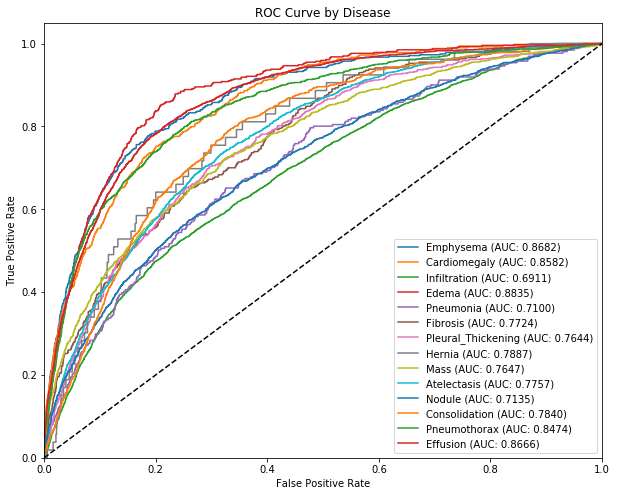

In [48]:
plot_auc_curves(e)

In [50]:
img_data_val.imgs[0]

('00000001_001.png', '/user/images_processed/all/00000001_001.png')

In [49]:
model_ft.forward( Variable(img_data_val[0][0].unsqueeze(0).cuda()) )

Variable containing:

Columns 0 to 9 
-5.0263  0.0632 -1.4509 -5.4086 -5.2723 -4.1413 -3.9578 -5.1651 -4.1192 -1.7841

Columns 10 to 13 
-3.7997 -3.7421 -4.7590 -2.6670
[torch.cuda.FloatTensor of size 1x14 (GPU 0)]

In [32]:
orig_model_ft = model_ft

In [26]:
orig_e = ModelEvaluator(model_ft, dataloaders['val'])
orig_e.run()

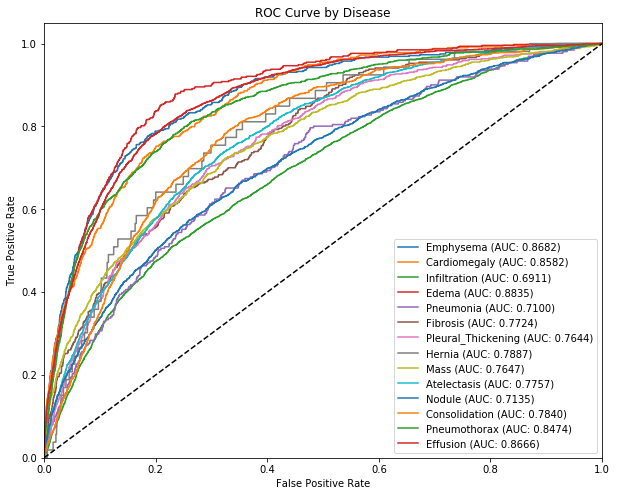

In [41]:
plot_auc_curves(orig_e)